In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

colors = ['#126E82', '#0A043C', '#F25287', '#F0A500', '#7D1935']
plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')
sns.set_palette(colors)

In [2]:
train_data = pd.read_csv(r'C:\Users\patri\Downloads\train.csv(1)\train.csv', parse_dates =['date'])
test_data = pd.read_csv(r'C:\Users\patri\Downloads\test.csv (1)\test.csv', parse_dates =['date'])
holidays = pd.read_csv(r'C:\Users\patri\Downloads\holidays_events.csv', parse_dates =['date'])
oil = pd.read_csv(r'C:\Users\patri\Downloads\oil.csv', parse_dates =['date'])
transaction = pd.read_csv(r'C:\Users\patri\Downloads\transactions.csv\transactions.csv', parse_dates =['date'])
stores = pd.read_csv(r'C:\Users\patri\Downloads\stores.csv')

In [3]:
# rename the column name of oil dataframe

oil.rename(columns={'dcoilwtico':'oilPrice'}, inplace=True)

# merge oil data into the train and test data

train = train_data.merge(oil, on='date')
test = test_data.merge(oil, on='date') 

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,oilPrice
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0.0,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0.0,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,NaN
4,4,2013-01-01,1,BOOKS,0.0,0.0,NaN


In [5]:
test.head()

,id,date,store_nbr,family,onpromotion,oilPrice
0,3000888,2017-08-16,1,AUTOMOTIVE,20.0,46.8
1,3000889,2017-08-16,1,BABY CARE,1.0,46.8
2,3000890,2017-08-16,1,BEAUTY,8.0,46.8
3,3000891,2017-08-16,1,BEVERAGES,560.0,46.8
4,3000892,2017-08-16,1,BOOKS,1.0,46.8


In [6]:
print("train shape :", train.shape)
print("test shape :", test.shape)

train shape : (2143746, 7)
test shape : (21384, 6)


In [7]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
train = train.merge(holidays[['date', 'type', 'transferred']], on='date')
train = train.merge(stores, on='store_nbr')
train.rename(columns={'type_x':'holiday_type', 'type_y':'store_type'}, inplace=True)

In [9]:
train['Year'] = train.date.dt.year
train['Year-Month'] = train['date'].apply(lambda x : x.strftime('%Y-%m'))
train['Month'] = train.date.dt.month
train['Day'] = train.date.dt.day

In [10]:
train.describe()

,id,store_nbr,sales,onpromotion,oilPrice,cluster,Year,Month,Day
count,3.528360e+05,352836.000000,352836.000000,352836.000000,322542.000000,352836.000000,352836.000000,352836.000000,352836.000000
mean,1.628316e+06,27.500000,370.968396,38.824936,65.369558,8.481481,2014.949495,7.272727,14.409091
std,7.954575e+05,15.585806,1196.785036,103.919082,25.489987,4.649741,1.258297,3.326720,9.313809
min,0.000000e+00,1.000000,0.000000,0.000000,27.960000,1.000000,2013.000000,1.000000,1.000000
25%,9.751990e+05,14.000000,0.000000,0.000000,44.880000,4.000000,2014.000000,4.000000,6.000000
50%,1.687554e+06,27.500000,12.000000,3.000000,52.010000,8.500000,2015.000000,7.000000,12.000000
75%,2.183840e+06,41.000000,202.000000,22.000000,95.250000,13.000000,2016.000000,11.000000,24.000000
max,3.000887e+06,54.000000,124717.000000,990.000000,107.950000,17.000000,2017.000000,12.000000,31.000000


In [11]:
train.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
oilPrice        30294
holiday_type        0
transferred         0
city                0
state               0
store_type          0
cluster             0
Year                0
Year-Month          0
Month               0
Day                 0
dtype: int64

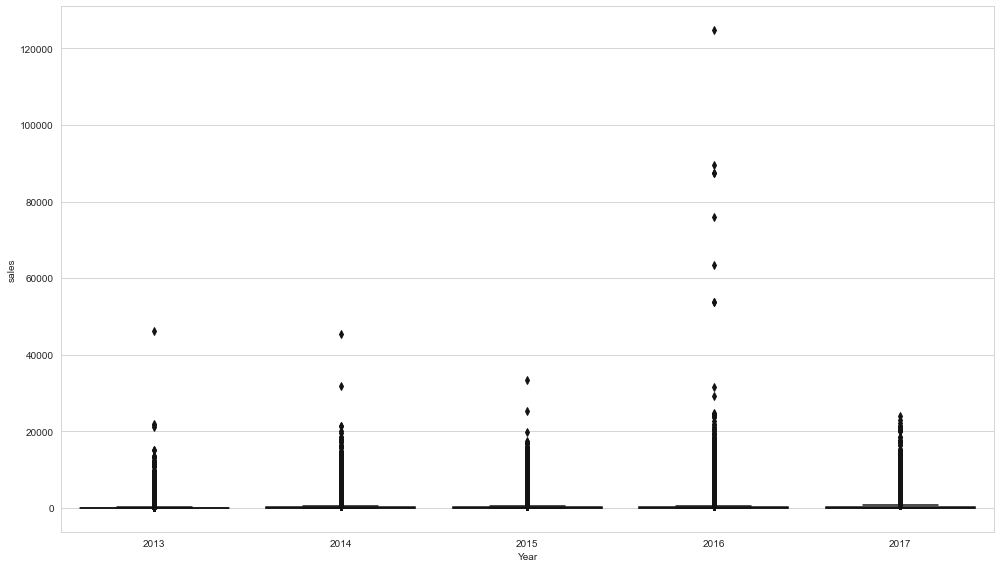

In [12]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=train, x='Year', y='sales')

plt.tight_layout()
plt.show()

# box plots to see distribution of sales in each year
#outliers in each year but 2016 has some extreme cases

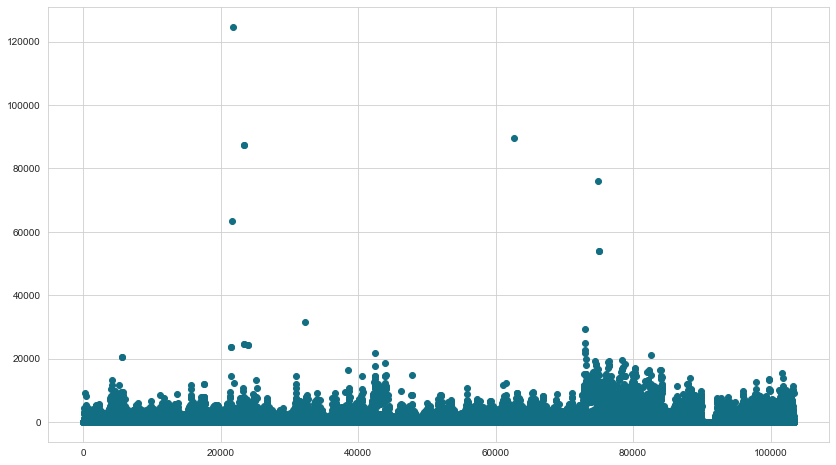

In [13]:
# examine sales in Year 2016

data2016 = train.loc[train.Year == 2016, 'sales']
data2016.reset_index(drop=True, inplace=True)

# plot
plt.figure(figsize=(14, 8))
plt.scatter(data2016.index, data2016.values)
plt.show()

In [14]:
# sales greater than 40000
train.loc[train.sales > 40000].shape # there are 10 entries for sales greater than 40,000.

# Let's remove values greater than 40,000.
train = train.loc[train.sales < 40000]
train.sales.max()

33274.0

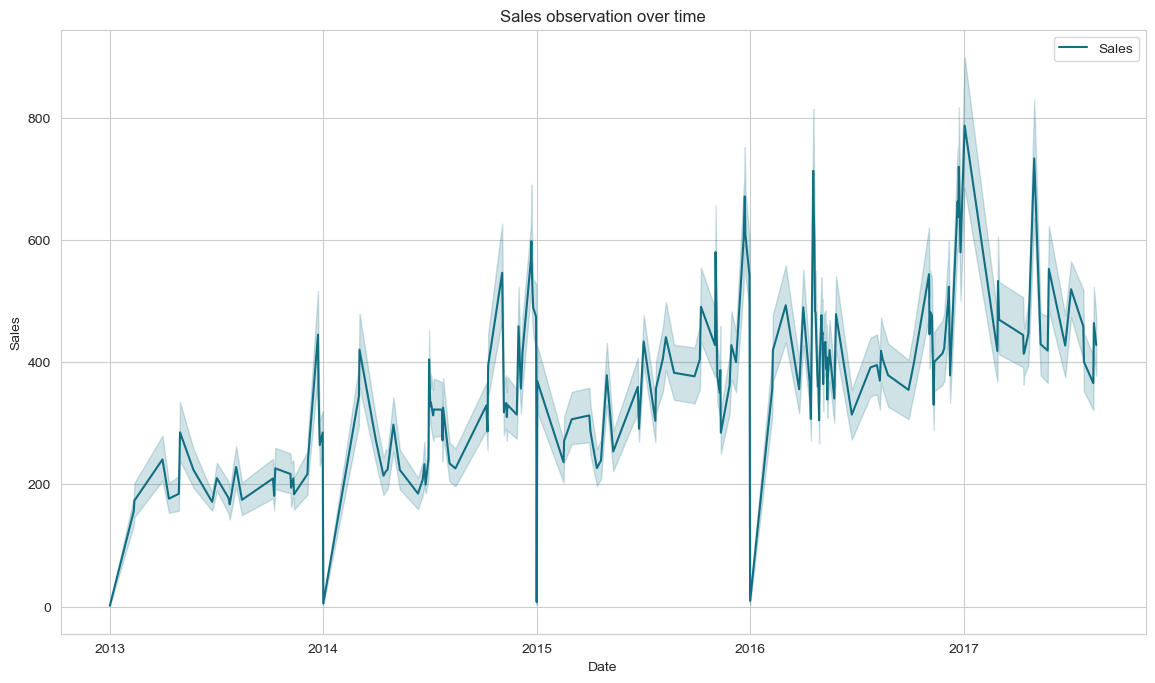

In [15]:
# Sales observation over time.
plt.figure(figsize=(14, 8),dpi=100)
sns.lineplot(data = train, x='date', y='sales', label='Sales')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("Sales observation over time")

plt.legend()
plt.show()

#There is increasing trend or growth in sales over the time

[]

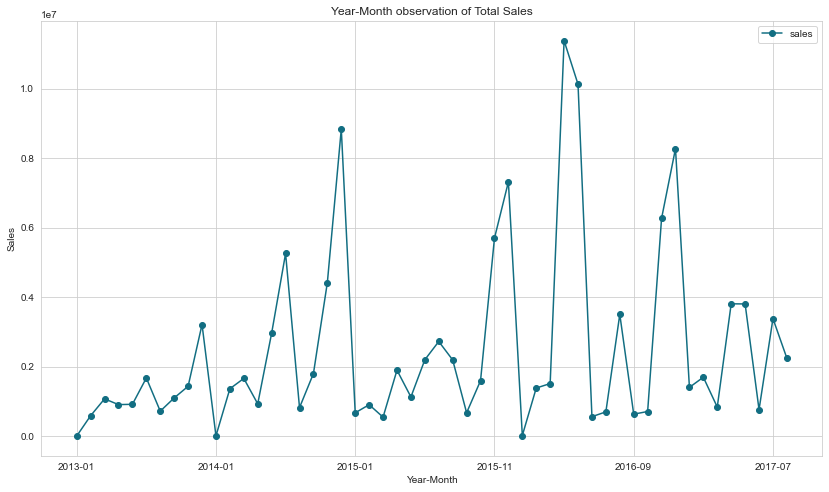

In [16]:
# Year-to-Year observation of sales

year_data = pd.DataFrame(train.groupby('Year-Month').sum()['sales'])

# plot
year_data.plot(kind='line', figsize=(14, 8), marker="o")

plt.xlabel("Year-Month")
plt.ylabel("Sales")
plt.title("Year-Month observation of Total Sales")
plt.plot()

#looks like an end of the year sales trend

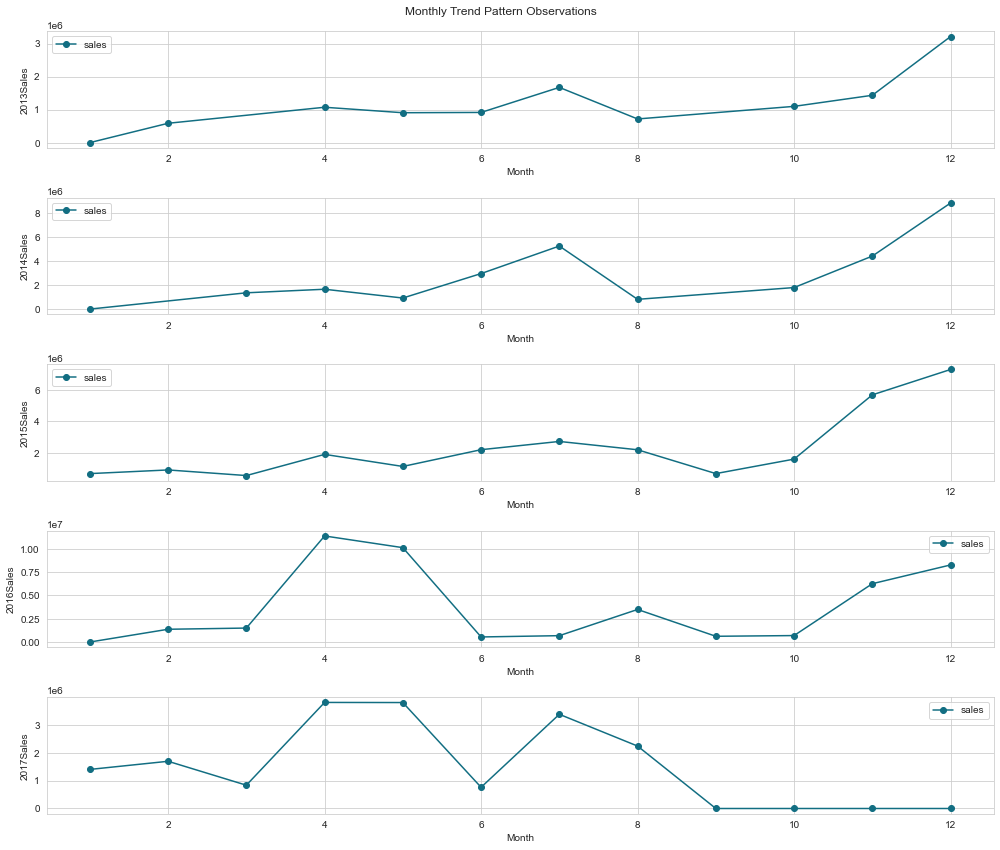

In [17]:
# Monthly observation of Sales for each year

monthly_sales = pd.DataFrame(train.groupby(by = ['Year', 'Month']).sum()['sales'])

# add 0 for remaining months(9, 10, 11, 12) in 2017.
re_months = [9, 10, 11, 12]
for month in re_months:
    monthly_sales.loc[(2017, month), :] = 0
    
yrs = [2013, 2014, 2015, 2016, 2017]

# Plots
fig, axs = plt.subplots(nrows = 5, ncols=1, figsize=(14, 12))
for i in range(len(yrs)):
    yr = yrs[i]
    axs[i] = monthly_sales.loc[yr].plot(ax=axs[i], marker="o", label=yr)
    axs[i].set_ylabel(str(yr)+'Sales')

fig.suptitle("Monthly Trend Pattern Observations")
plt.legend()
plt.tight_layout()
plt.show()

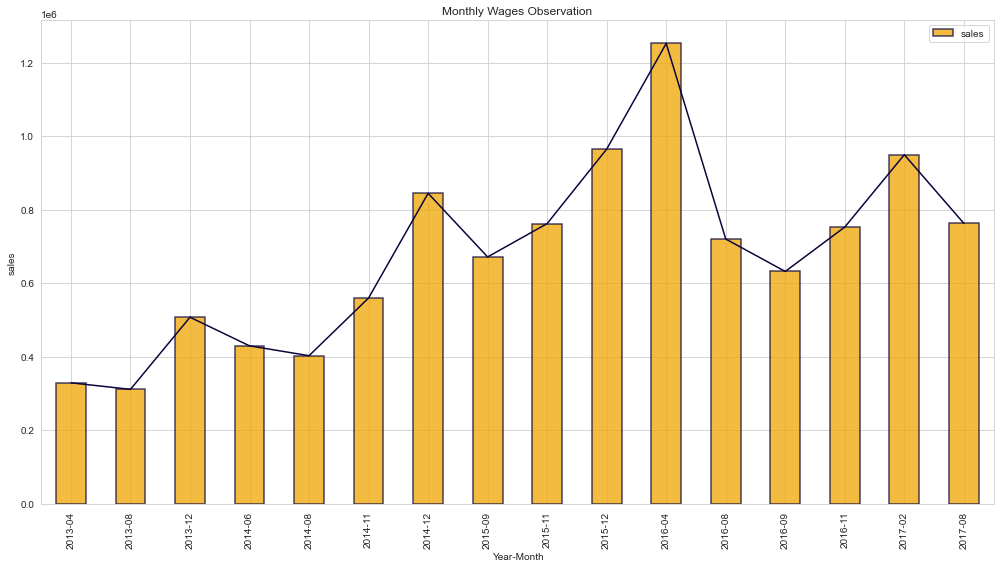

In [18]:
# prepare data
filter1 = (train.Day == 15) 
filter2 = (train.Day.apply(lambda x: x in [31, 30, 29, 28]))

Sales = train.loc[(filter1 | filter2), ['date','Year-Month','sales']]
sales_data = pd.DataFrame(Sales.groupby(by=['Year-Month']).sum())

#plot
sales_data.plot(kind='bar', figsize=(14, 8), edgecolor=colors[1], color=colors[-2], fill=True, alpha=0.75, linewidth=1.5)
sns.lineplot(data = sales_data, x = sales_data.index, y = 'sales', color=colors[1])

plt.title('Monthly Wages Observation')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

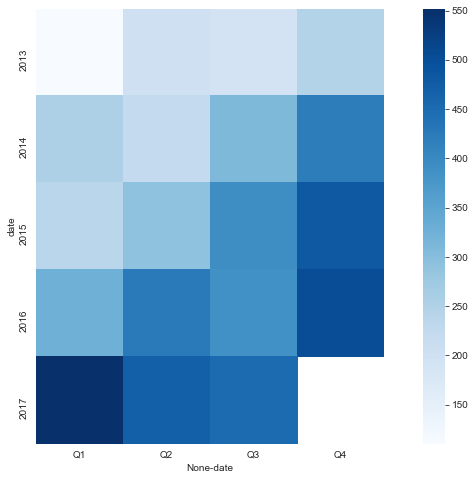

In [19]:
# prepare data
d = train[['date', 'sales']]
d.set_index('date', inplace=True)
ptable = pd.pivot_table(data=d, index=d.index.year, columns=d.index.quarter)

# plot
plt.figure(figsize=(14, 8))
sns.heatmap(ptable, square=True, cmap='Blues', xticklabels=["Q1", "Q2", "Q3", "Q4"])
plt.show()

In [20]:
# Groupby Sales by Quarter
# Only use upto 2016 because we have partial data for 2017
data_2016 = d.loc[:'2016']
avg_2016 = np.int(data_2016.mean())

# Avg sales per quarter
qrt_avg = data_2016.groupby(data_2016.index.quarter)["sales"].mean()

# Groupby quarter
qrt_table = pd.pivot_table(data_2016, index=data_2016.index.quarter, columns=data_2016.index.year)

# add qrt_avg to qrt_table
qrt_table["avg"] = qrt_avg

# Additive Seasonality Factor: Subtract mean from avg column
qrt_table["additive"] = (qrt_table["avg"] - avg_2016).round(2)

# Multiplicative Seasonality Factor: Divide mean from avg column
qrt_table["multiplicative"] = (qrt_table["avg"]/avg_2016).round(2)

qrt_table.index.name="Quarters"
print("Seasonal Factor Analysis Table")
qrt_table

Seasonal Factor Analysis Table


sales                                             avg additive  \
date            2013        2014        2015        2016                        
Quarters                                                                        
1         110.351665  256.548073  237.980228  326.811703  245.291179  -109.71   
2         202.983288  222.559189  292.943834  426.904533  328.671785   -26.33   
3         191.659155  309.852124  391.762348  387.365946  321.080238   -33.92   
4         247.927403  422.325064  482.029985  503.159575  424.146800    69.15   

         multiplicative  
date                     
Quarters                 
1                  0.69  
2                  0.93  
3                  0.90  
4                  1.19

Stationarity
Time series is Stationary if it:

Constant Mean
Constant Variance
Constant Covariance

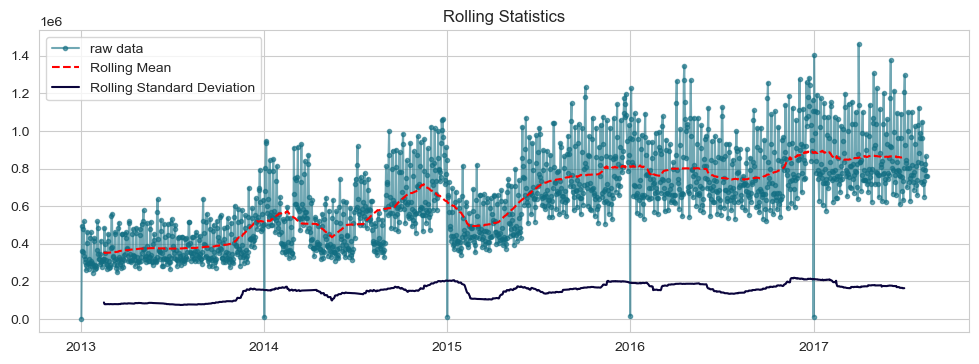

In [21]:
# prepare_data 
data = pd.DataFrame(train_data.groupby(by=['date']).sum()['sales'])

def test_stationarity(timeseries, title):
    
    # calculating rolling statistics.
    roll_mean = timeseries['sales'].rolling(window = 91,  center=True).mean()
    roll_std = timeseries['sales'].rolling(window = 91,  center=True).std()

    # plotting rolling statistics with orignal data.
    plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(timeseries.sales, label= title, marker=".", alpha=0.6)
    plt.plot(roll_mean, label="Rolling Mean", color="red", linestyle="--")
    plt.plot(roll_std, label="Rolling Standard Deviation")

    plt.title("Rolling Statistics")
    plt.legend()
    plt.show()

test_stationarity(data, 'raw data')

#this is not stationary-both std and mean increase over time

In [22]:
# coefficient of variance. 
cv = data.sales.std()/data.sales.mean()
cv

0.3676698237927686

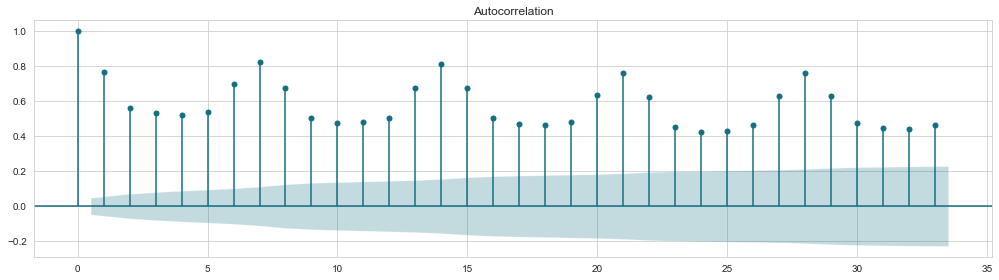

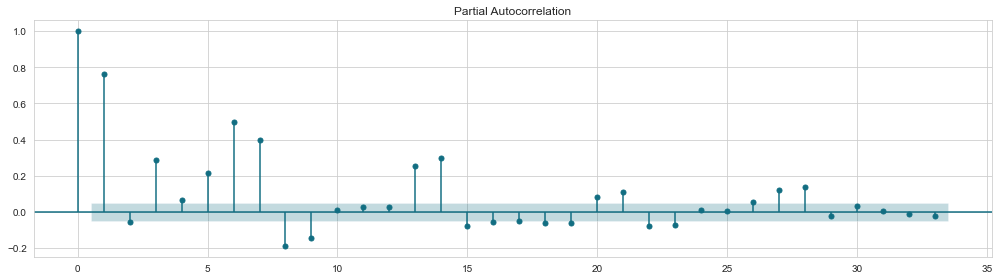

In [23]:
# if covariance is constant or not using acf plot and pacf plot of statsmodels.
plt.rcParams['figure.figsize'] = (14, 4);
plot_acf(data.sales);
plt.tight_layout()
plot_pacf(data.sales);
plt.tight_layout()